# Imports

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import lime.lime_tabular
import shap
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import train_test_split
from SyntheticDataset import SyntheticDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Setup

In [2]:
config_file = open('config.json')
config_vars = json.load(config_file)
config_file.close()

logs_dir = config_vars["logs_dir"] + "/synth_test"

In [3]:
config_file = open('visual_config.json')
config_vars = json.load(config_file)
config_file.close()

shap_colors_neg = config_vars["shap_colors"]["negative"]
shap_colors_pos = config_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = config_vars["title_font_size"]
label_size = config_vars["labels_font_size"]

# Binary Classification

## Create the Dataset

In [4]:
perf_analysis = PerformanceAnalysis()

min_val = -100
max_val = 100
num_rows = 200
num_features = 10
num_classes = 2
# rand_coef = [[0.9, 0.9],
#              [0.8, 0.8],
#              [0.7, 0.7],
#              [0.6, 0.6],
#              [0.5, 0.5],
#              [0.4, 0.4],
#              [0.3, 0.3],
#              [0.2, 0.2],
#              [0.1, 0.1],
#              [0.05, 0.05]]

rand_coef = [[0.95 - 1 / (num_features * 2) * x, 0.95 - 1 / (num_features * 2) * x] for x in range(num_features)]
features_names = ["Var" + (str(x)) for x in range(num_features)]
dataset = SyntheticDataset(min_val, max_val, num_rows, num_features, num_classes, rand_coef, seed=42)
dataset.generate()
dataset.get_data()

array([[  54.79120971, -100.        , -100.        , ...,  -74.37727346,
          -9.92281242,    0.        ],
       [-100.        ,   28.77302402, -100.        , ..., -100.        ,
          51.61754802,    0.        ],
       [  94.13960488,   78.62422426,   55.67669941, ...,   48.95243118,
        -100.        ,    0.        ],
       ...,
       [ 100.        ,  -34.43845586,  100.        , ...,  100.        ,
         100.        ,    1.        ],
       [ -48.65564769,   93.95431577,   56.94440417, ...,   63.64547053,
          16.83242984,    1.        ],
       [  85.9197944 ,  -76.96278934,   12.77248069, ...,    2.44859422,
         -48.28856437,    1.        ]])

In [5]:
rand_coef

[[0.95, 0.95],
 [0.8999999999999999, 0.8999999999999999],
 [0.85, 0.85],
 [0.7999999999999999, 0.7999999999999999],
 [0.75, 0.75],
 [0.7, 0.7],
 [0.6499999999999999, 0.6499999999999999],
 [0.5999999999999999, 0.5999999999999999],
 [0.5499999999999999, 0.5499999999999999],
 [0.49999999999999994, 0.49999999999999994]]

## Split the Dataset

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
    dataset.get_x(),dataset.get_y(), test_size=0.20, shuffle=True, stratify=dataset.get_y(), random_state=42)

X_train_pd = pd.DataFrame(X_train, columns=features_names)
X_test_pd = pd.DataFrame(X_test, columns=features_names)

## Instance to extract local explanations for all models

In [7]:
Exp_index = 3
Exp_inst = X_test[Exp_index, :]
Exp_inst_pd = X_test_pd.iloc[Exp_index, :]
Exp_inst_class = Y_test[Exp_index]
print(f"Instance:\n{Exp_inst_pd}\n\nClass: {Exp_inst_class}") #"Name" and "dtype" are not part of the instance, they must be ignored

Instance:
Var0    -80.423344
Var1    -44.815232
Var2    100.000000
Var3    -91.508409
Var4    -10.356782
Var5    -46.957309
Var6    -21.452998
Var7    -14.979474
Var8     75.882347
Var9    -45.931806
Name: 3, dtype: float64

Class: 1


# Classification

## <i>Logistic Regression</i> (LR)

In [8]:
lr_fit_init = time.time()
lr_clf = LogisticRegression(solver="liblinear", max_iter=100, C=0.1, random_state=42).fit(X_train, Y_train)
lr_fit_fin = time.time()
lr_duration = lr_fit_fin - lr_fit_init

Metrics                Values
accuracy             0.875000
false-positive rate  0.000000
false-negative rate  0.250000
precision            1.000000
recall               0.750000
f-score              0.857143

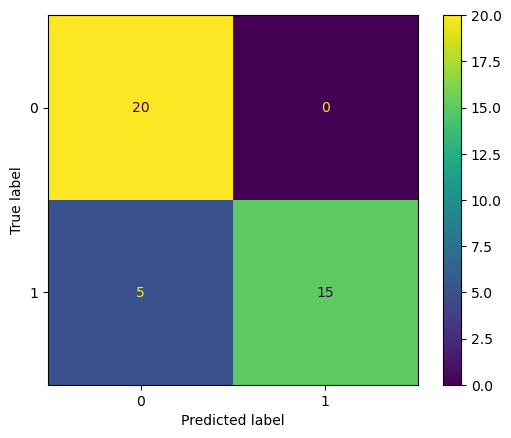

In [9]:
lr_ye = lr_clf.predict(X_test)

lr_cm = confusion_matrix(Y_test, lr_ye)
lr_metrics = perf_analysis.compute_metrics(lr_cm)
display(lr_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, lr_ye)

lr_y2d = lr_clf.predict_proba(X_test)[:, 1]

plt.show()

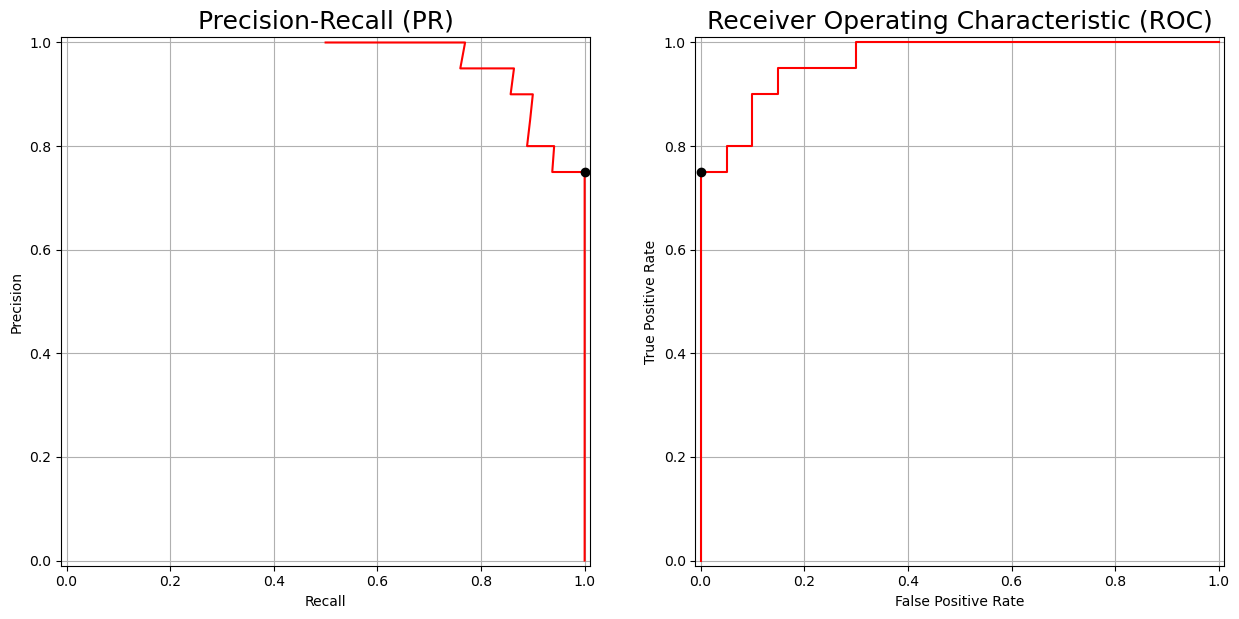

In [10]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
perf_analysis.plot_PR(Y_test, lr_cm, lr_y2d)
plt.subplot(1,2,2)
perf_analysis.plot_ROC(Y_test, lr_cm, lr_y2d)

plt.show()

### Extract Explanations

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [11]:
lr_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
lr_LIME_explanation = lr_LIME_explainer.explain_instance(Exp_inst, lr_clf.predict_proba)

In [12]:
lr_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [13]:
shap.initjs()

In [14]:
lr_shap_init = time.time()
lr_SHAP_exp = shap.KernelExplainer(lr_clf.predict_proba, shap.sample(X_train_pd, 20, random_state=42), random_state=42)
lr_shap_loc_values = np.array(lr_SHAP_exp.shap_values(Exp_inst_pd))

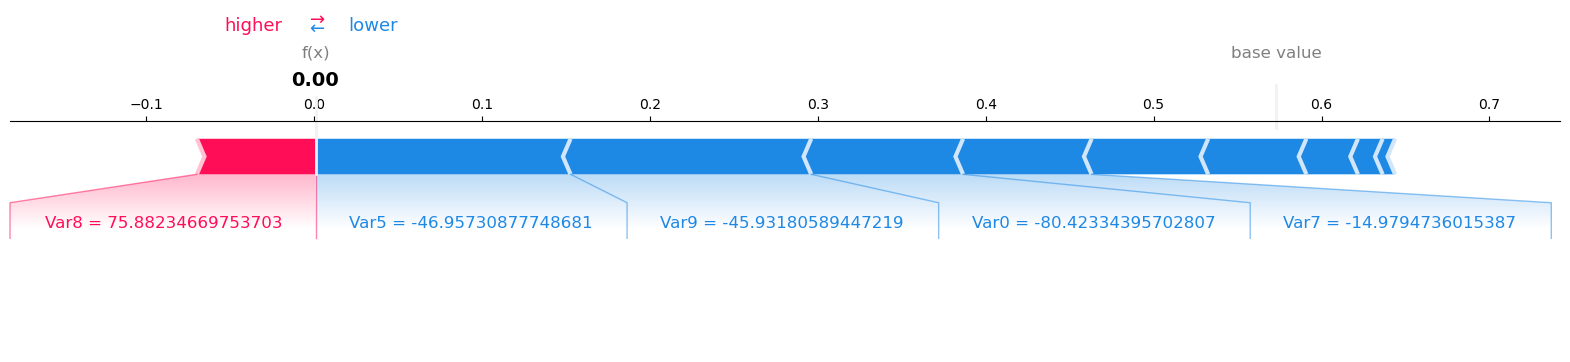

In [15]:
shap.force_plot(lr_SHAP_exp.expected_value[1], lr_shap_loc_values[1, :], Exp_inst_pd, matplotlib=True)

#### Global (SHAP)

In [16]:
lr_shap_global_values = lr_SHAP_exp.shap_values(X_test_pd)
lr_shap_fin = time.time()
lr_shap_dur = lr_shap_fin - lr_shap_init

  0%|          | 0/40 [00:00<?, ?it/s]

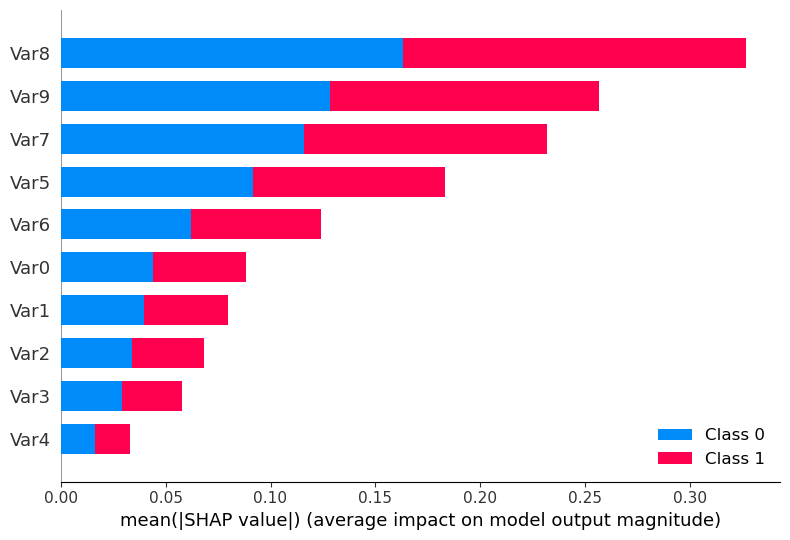

In [17]:
shap.summary_plot(lr_shap_global_values, X_test_pd, plot_type="bar")

## <i>Random Forest</i> (RF)

In [18]:
rf_fit_init = time.time()
rf_clf = RandomForestClassifier(n_estimators=1000, bootstrap=False, max_features="sqrt", random_state=42).fit(X_train, Y_train)
rf_fit_fin = time.time()
rf_duration = rf_fit_fin - rf_fit_init

Metrics              Values
accuracy                1.0
false-positive rate     0.0
false-negative rate     0.0
precision               1.0
recall                  1.0
f-score                 1.0

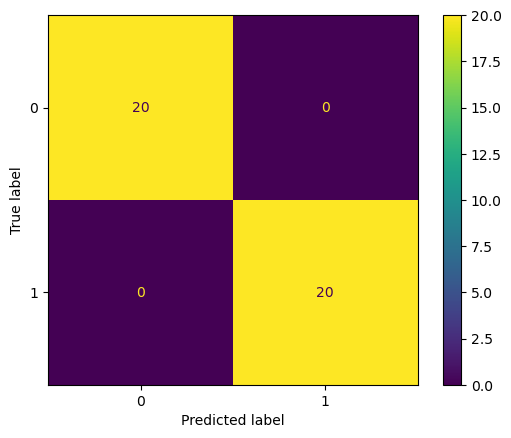

In [19]:
rf_ye = rf_clf.predict(X_test)

rf_cm = confusion_matrix(Y_test, rf_ye)
rf_metrics = perf_analysis.compute_metrics(rf_cm)
display(rf_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, rf_ye)

rf_y2d = rf_clf.predict_proba(X_test)[:, 1]

plt.show()

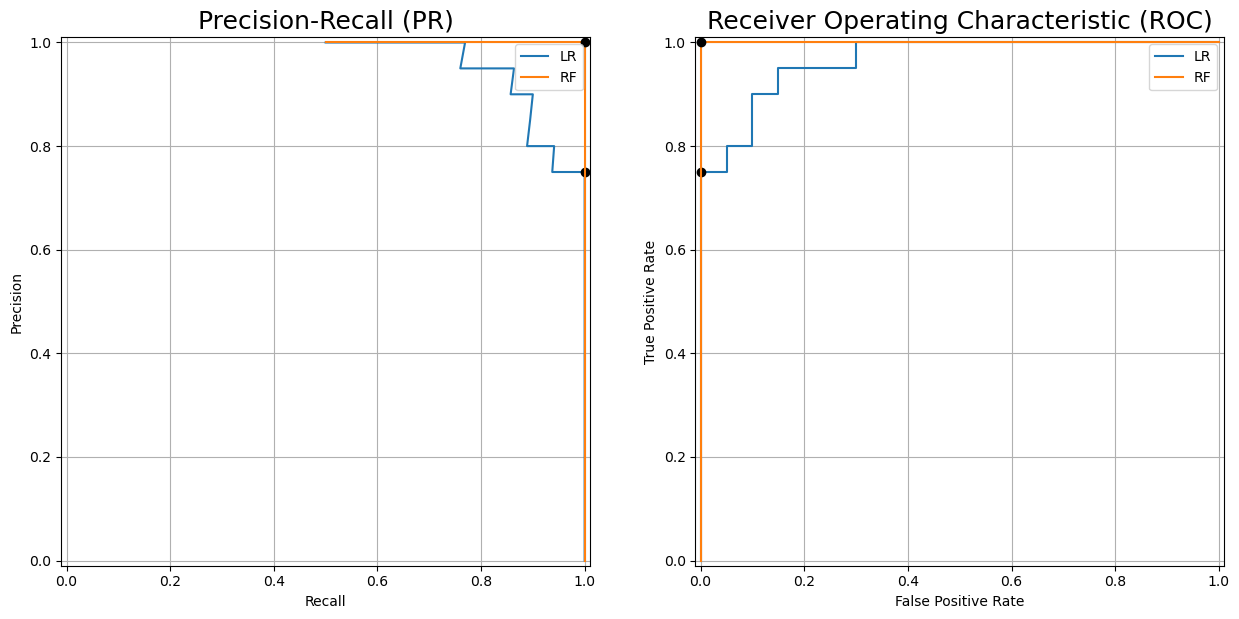

In [20]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR", "RF"])

plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test], [lr_cm, rf_cm], [lr_y2d, rf_y2d], ["LR","RF"])


plt.show()

### Extract Explanations 

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [21]:
rf_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
rf_LIME_explanation = rf_LIME_explainer.explain_instance(Exp_inst, rf_clf.predict_proba)

In [22]:
rf_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [23]:
rf_shap_init = time.time()
rf_SHAP_exp = shap.TreeExplainer(rf_clf, random_state=42)
rf_shap_loc_values = np.array(rf_SHAP_exp.shap_values(Exp_inst_pd))

In [24]:
shap.force_plot(rf_SHAP_exp.expected_value[1], rf_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [25]:
rf_shap_global_values = rf_SHAP_exp.shap_values(X_test_pd)
rf_shap_fin = time.time()
rf_shap_dur = rf_shap_fin - rf_shap_init

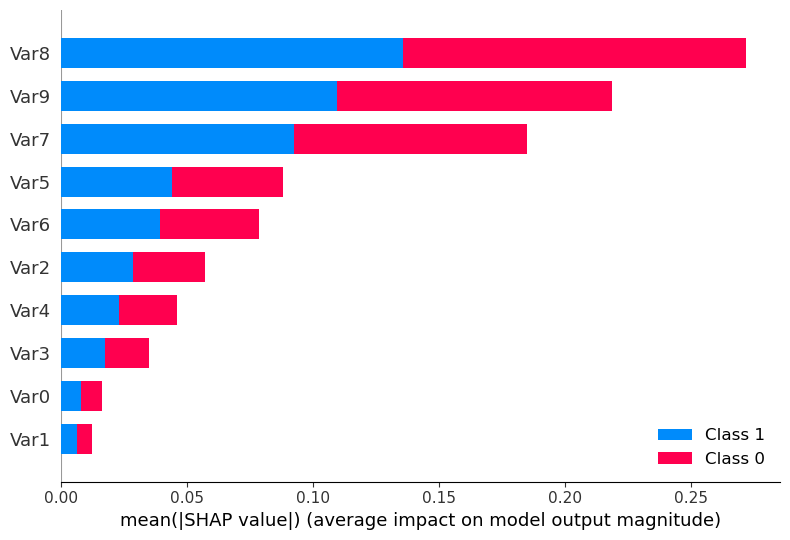

In [26]:
shap.summary_plot(rf_shap_global_values, X_test_pd, plot_type="bar")

## <i> Support Vector Machines</i> (SVM)

In [27]:
svm_fit_init = time.time()
svm_clf = SVC(kernel="rbf", C=0.1, cache_size=1000, probability=True, random_state=42).fit(X_train, Y_train)
svm_fit_fin = time.time()
svm_duration = svm_fit_fin - svm_fit_init

Metrics                Values
accuracy             0.925000
false-positive rate  0.000000
false-negative rate  0.150000
precision            1.000000
recall               0.850000
f-score              0.918919

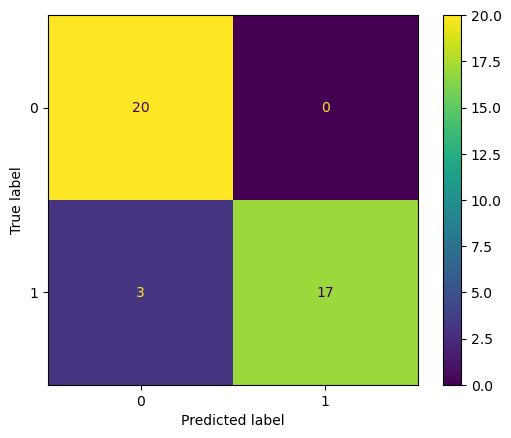

In [28]:
svm_ye = svm_clf.predict(X_test)

svm_cm = confusion_matrix(Y_test, svm_ye)
svm_metrics = perf_analysis.compute_metrics(svm_cm)
display(svm_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, svm_ye)

svm_y2d = svm_clf.decision_function(X_test)

plt.show()

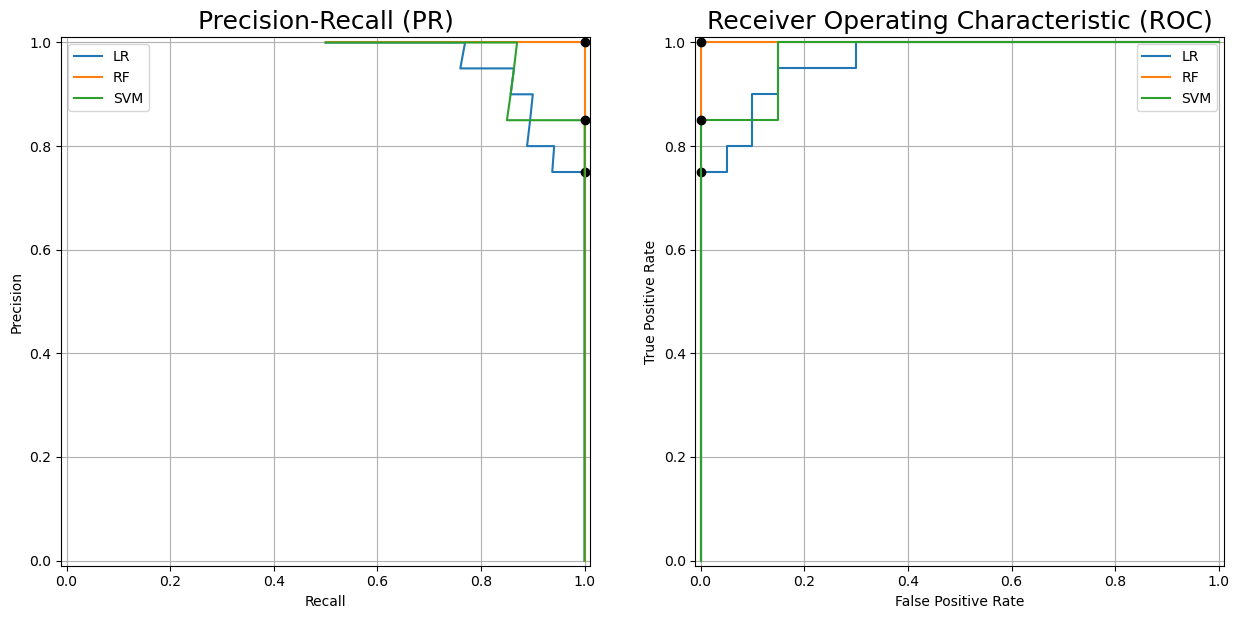

In [29]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR", "RF", "SVM"])
plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm], [lr_y2d, rf_y2d, svm_y2d], ["LR","RF", "SVM"])

plt.show()

### Extract Explanations

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [30]:
svm_LIME_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, random_state=42)
svm_LIME_explanation = svm_LIME_explainer.explain_instance(Exp_inst, svm_clf.predict_proba)

In [31]:
svm_LIME_explanation.show_in_notebook(show_table=True)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [32]:
svm_shap_init = time.time()
svm_SHAP_exp = shap.KernelExplainer(svm_clf.predict_proba, shap.sample(X_train_pd, 20, random_state=42), random_state=42)
svm_shap_loc_values = np.array(svm_SHAP_exp.shap_values(Exp_inst_pd))

In [33]:
shap.force_plot(svm_SHAP_exp.expected_value[1], svm_shap_loc_values[1, :], Exp_inst_pd)

#### Global (SHAP)

In [34]:
svm_shap_global_values = svm_SHAP_exp.shap_values(X_test_pd)
svm_shap_fin = time.time()
svm_shap_dur = svm_shap_fin - svm_shap_init

  0%|          | 0/40 [00:00<?, ?it/s]

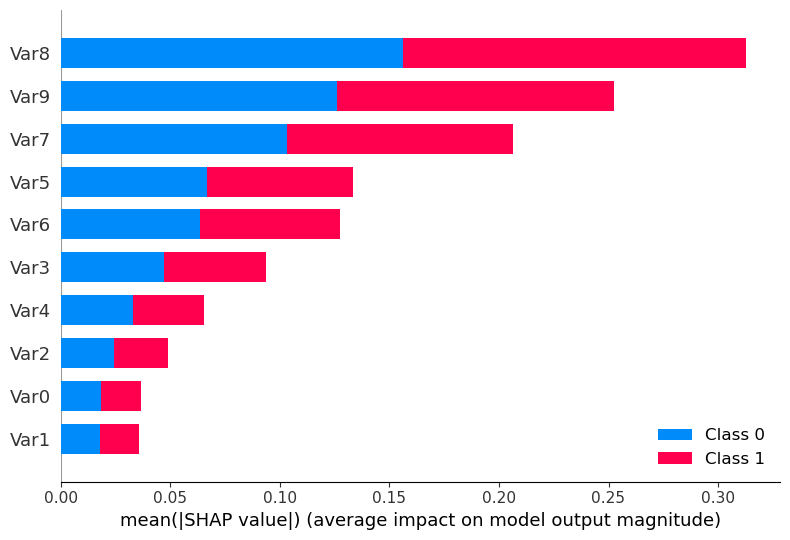

In [35]:
shap.summary_plot(svm_shap_global_values, X_test_pd, plot_type="bar")

## <i>Explainable Boosting Machine</i> (EBM)

In [36]:
ebm_fit_init = time.time()
ebm_clf = ExplainableBoostingClassifier(max_bins=1024, smoothing_rounds=1000, cyclic_progress=0, random_state=42)
ebm_clf.fit(X_train_pd, Y_train)
ebm_fit_fin = time.time()
ebm_duration = ebm_fit_fin - ebm_fit_init

Metrics                Values
accuracy             0.950000
false-positive rate  0.000000
false-negative rate  0.100000
precision            1.000000
recall               0.900000
f-score              0.947368

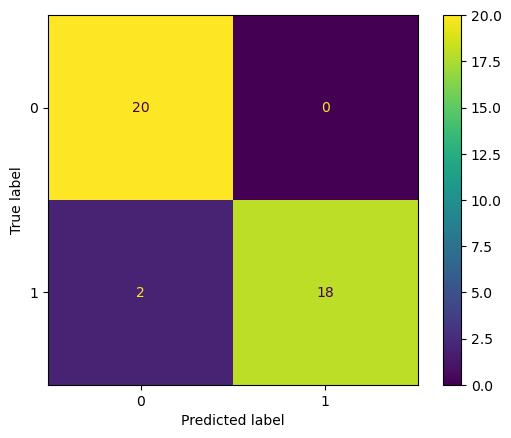

In [37]:
ebm_ye = ebm_clf.predict(X_test)

ebm_cm = confusion_matrix(Y_test, ebm_ye)
ebm_metrics = perf_analysis.compute_metrics(ebm_cm)
display(ebm_metrics)

ConfusionMatrixDisplay.from_predictions(Y_test, ebm_ye)

ebm_y2d = ebm_clf.decision_function(X_test)

plt.show()

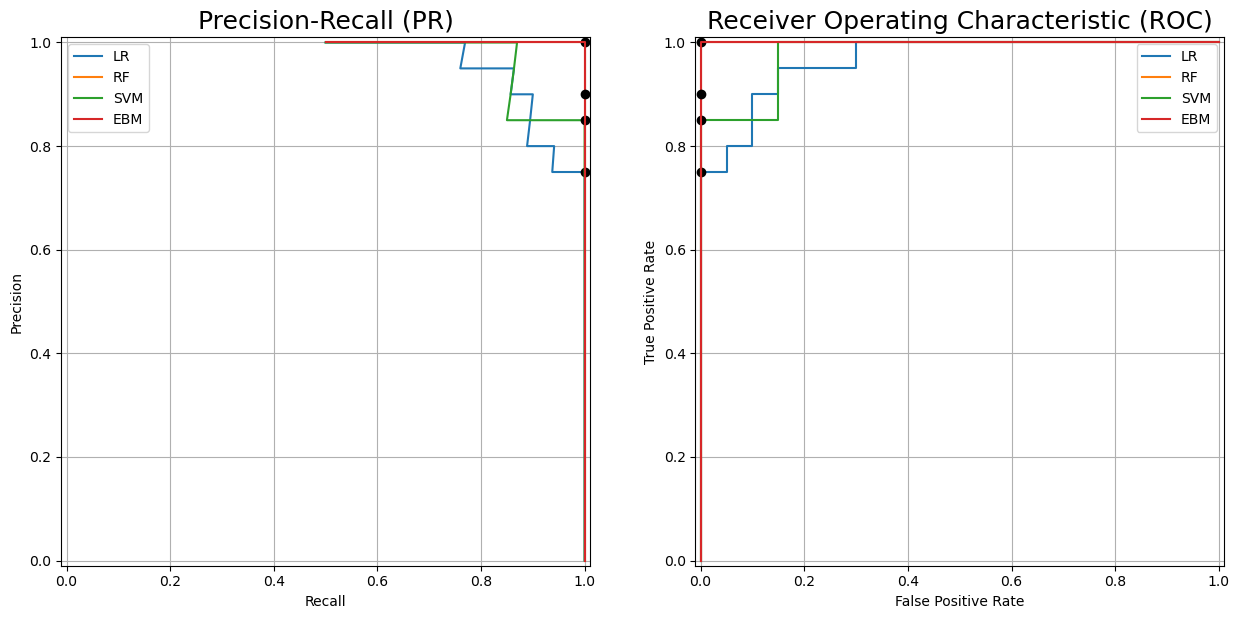

In [38]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR", "RF", "SVM", "EBM"])

plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR","RF", "SVM", "EBM"])

plt.show()

### Extract Explanations

#### Local

In [39]:
ebm_local = ebm_clf.explain_local(X_test, Y_test)
show(ebm_local)

<!-- http://127.0.0.1:7001/2361452577168/ -->

#### Global

In [40]:
ebm_global = ebm_clf.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2361499175376/ -->

# Summary

In [41]:
visual = Visualization()

## Time

In [42]:
time_pd_cols = ["LR", "RF", "SVM", "EBM"]
fit_durs = [round(x, 1) for x in [lr_duration, rf_duration, svm_duration, ebm_duration]]
shap_durs = [round(x, 1) for x in [lr_shap_dur, rf_shap_dur, svm_shap_dur]]
pd_vals = [fit_durs, shap_durs]

duration_summary = pd.DataFrame(pd_vals, columns=time_pd_cols, index=["Fit", "SHAP"])
duration_summary.columns.names = ["Task"]
duration_summary

Task   LR   RF   SVM   EBM
Fit   0.0  1.5   0.0  37.1
SHAP  7.8  0.2  21.6   NaN

In [43]:
latex_str = duration_summary.columns.name + "".join([" & " + x for x in duration_summary.columns]) + " \\\ \n"
for i, row in duration_summary.iterrows():

    aux_str = i
    for k in row:
        aux_str += f" & {k}"

    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/synth_bin_test_duration.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Metrics

In [44]:
lr_metrics = lr_metrics.rename(columns={"Values": "LR"})
lr_metrics["LR"] = [round(x, 2) for x in lr_metrics["LR"]]
rf_metrics = rf_metrics.rename(columns={"Values": "RF"})
rf_metrics["RF"] = [round(x, 2) for x in rf_metrics["RF"]]
svm_metrics = svm_metrics.rename(columns={"Values": "SVM"})
svm_metrics["SVM"] = [round(x, 2) for x in svm_metrics["SVM"]]
ebm_metrics = ebm_metrics.rename(columns={"Values": "EBM"})
ebm_metrics["EBM"] = [round(x, 2) for x in ebm_metrics["EBM"]]

overall_metrics = pd.concat([lr_metrics, rf_metrics, svm_metrics, ebm_metrics], axis=1)
display(overall_metrics)

Metrics                LR   RF   SVM   EBM
accuracy             0.88  1.0  0.93  0.95
false-positive rate  0.00  0.0  0.00  0.00
false-negative rate  0.25  0.0  0.15  0.10
precision            1.00  1.0  1.00  1.00
recall               0.75  1.0  0.85  0.90
f-score              0.86  1.0  0.92  0.95

In [45]:
latex_str = overall_metrics.columns.name  + ''.join([" & " + x for x in overall_metrics.columns]) + " \\\ \n"

In [46]:
for i, row in overall_metrics.iterrows():
    
    aux_str = i
    for k in row:
        aux_str += f" & {k}"

    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/synth_bin_test_metrics.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Confusion Matrices

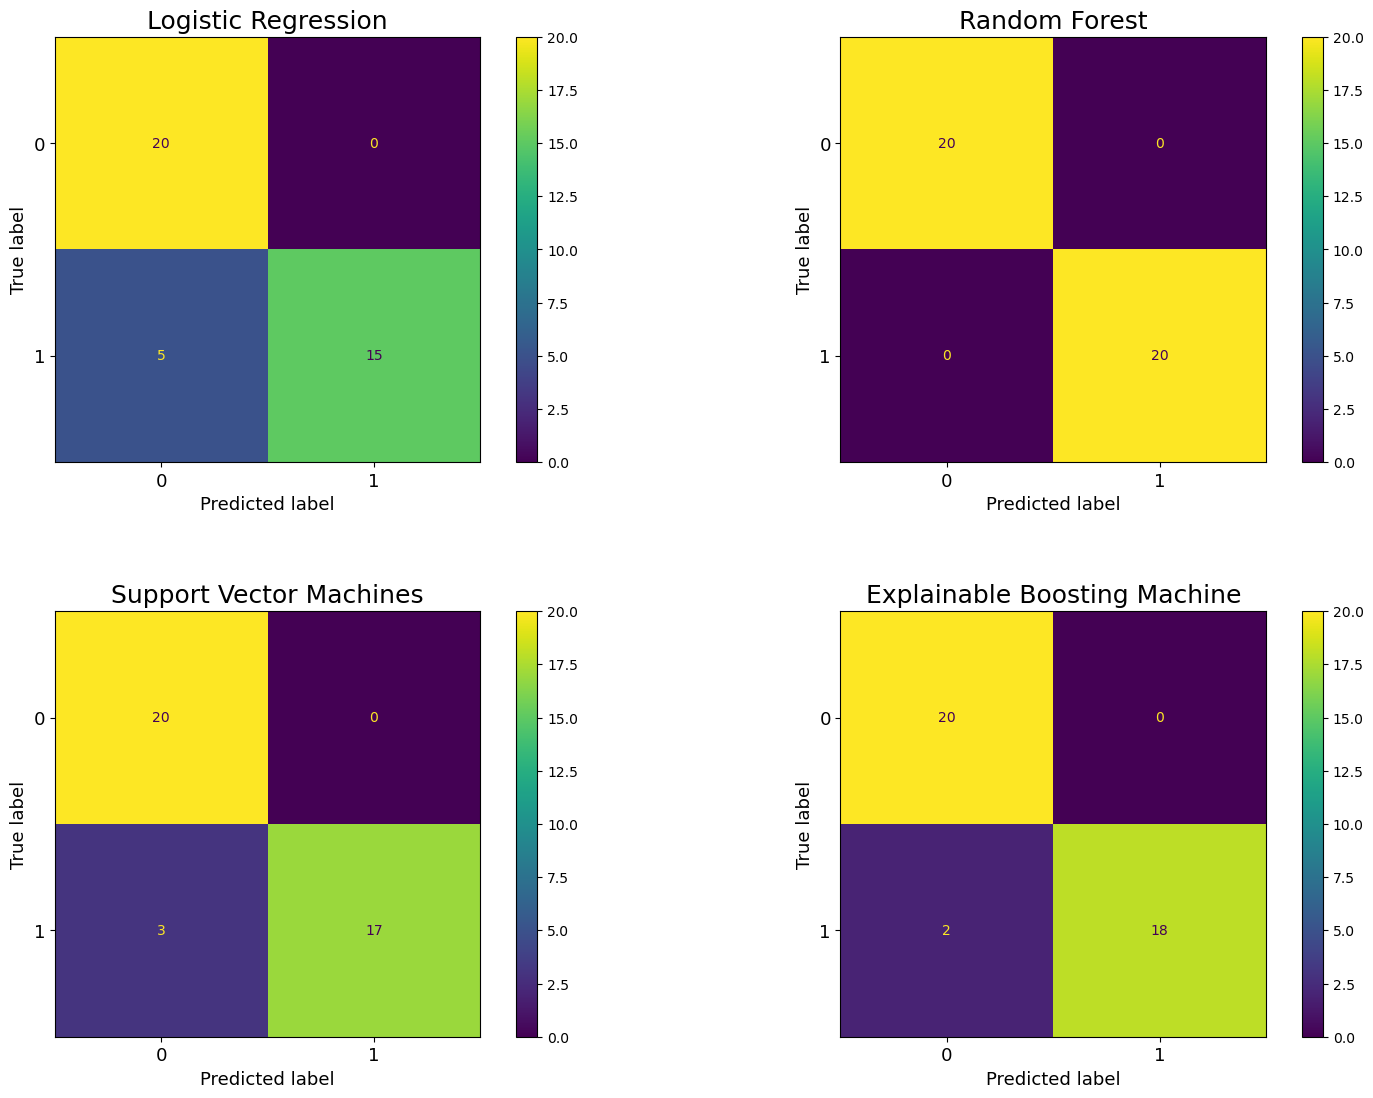

In [47]:
visual.confusion_matrices_pred([Y_test, Y_test, Y_test, Y_test], 
                          [lr_ye, rf_ye, svm_ye, ebm_ye],
                          nrows=2, 
                          ncols=2, 
                          figsize=(15,10),
                          title_size=title_size,
                          label_size=label_size,
                          titles=["Logistic Regression", "Random Forest", "Support Vector Machines", "Explainable Boosting Machine"]
                          )

plt.savefig(f"{logs_dir}/synth_bin_test_conf_matrices.png", bbox_inches="tight")

plt.show()

## Curves

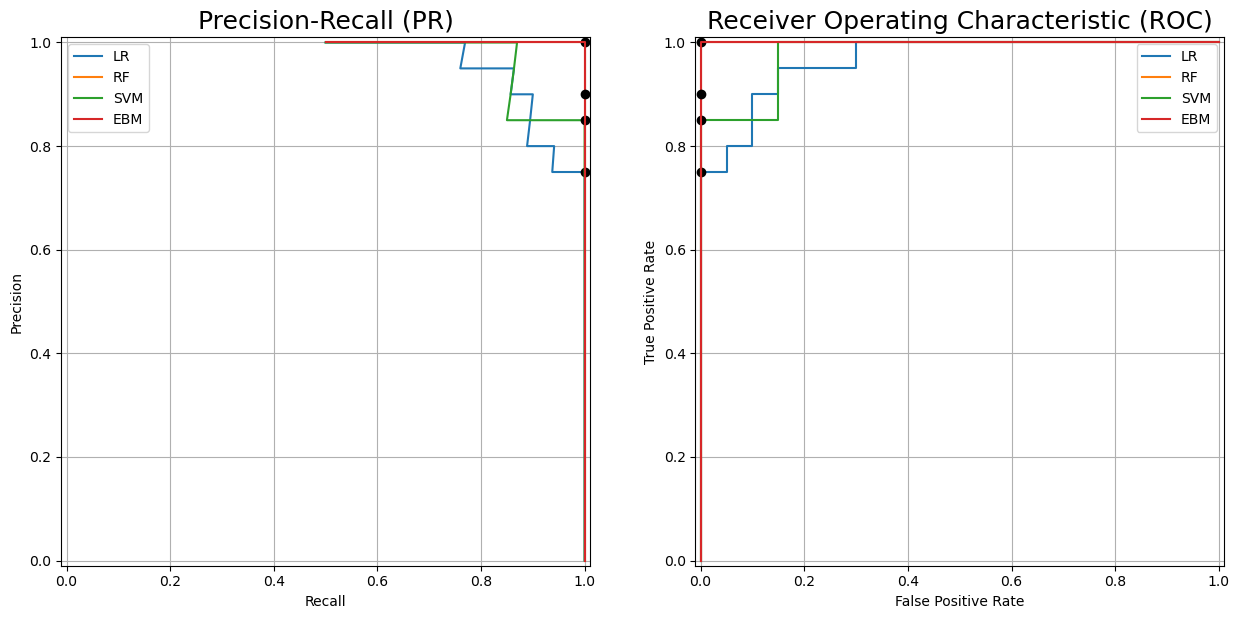

In [48]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
perf_analysis.compare_PR([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR", "RF", "SVM", "EBM"])
plt.subplot(1,2,2)
perf_analysis.compare_ROC([Y_test, Y_test, Y_test, Y_test], [lr_cm, rf_cm, svm_cm, ebm_cm], [lr_y2d, rf_y2d, svm_y2d, ebm_y2d], ["LR","RF", "SVM", "EBM"])

plt.savefig(f"{logs_dir}/synth_bin_test_PR_ROC.png", bbox_inches="tight")
plt.show()

## Local Explanations

### LIME

In [49]:
lr_LIME_explanation.show_in_notebook(show_table=True)
lr_LIME_explanation.save_to_file(f"{logs_dir}/synth_bin_test_LR_LIME.html")

In [50]:
rf_LIME_explanation.show_in_notebook(show_table=True)
rf_LIME_explanation.save_to_file(f"{logs_dir}/synth_bin_test_RF_LIME.html")

In [51]:
svm_LIME_explanation.show_in_notebook(show_table=True)
svm_LIME_explanation.save_to_file(f"{logs_dir}/synth_bin_test_SVM_LIME.html")

### SHAP & EBM

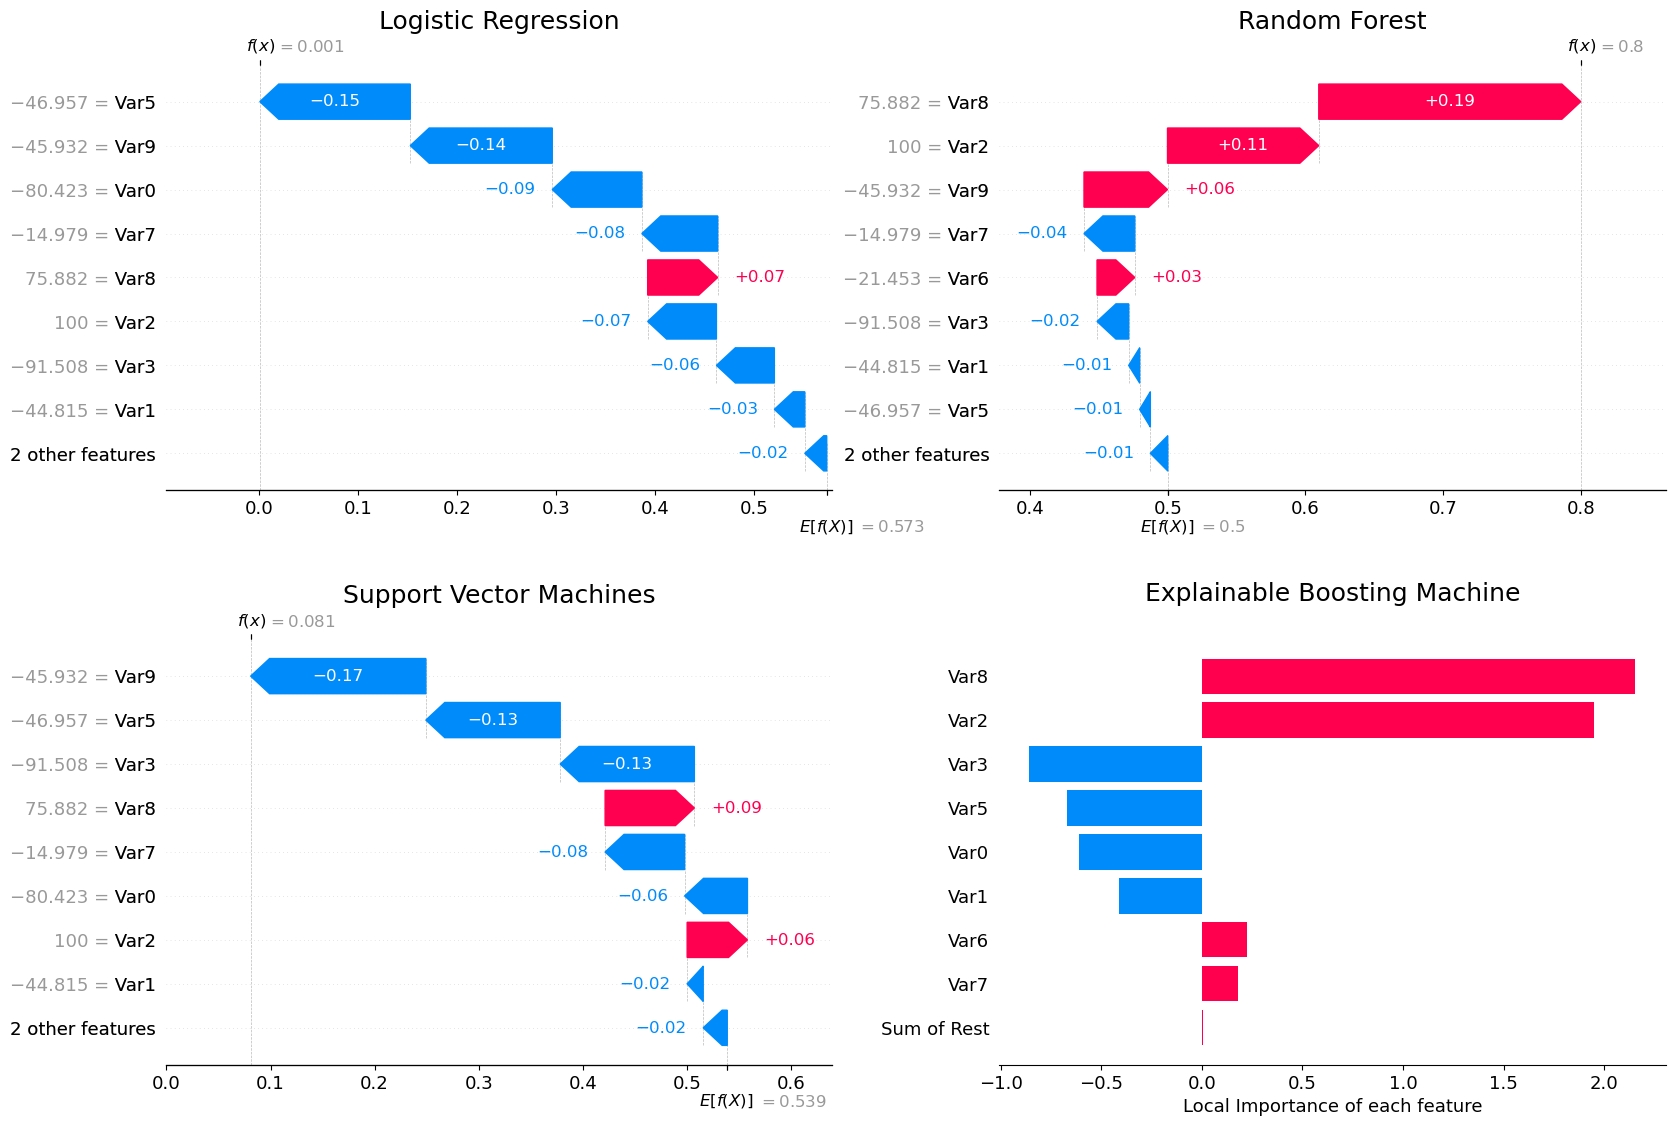

In [52]:
explanations = [shap.Explanation(lr_shap_loc_values[1, :], lr_SHAP_exp.expected_value[1], data=Exp_inst_pd),
                shap.Explanation(rf_shap_loc_values[1, :], rf_SHAP_exp.expected_value[1], data=Exp_inst_pd),
                shap.Explanation(svm_shap_loc_values[1, :], svm_SHAP_exp.expected_value[1], data=Exp_inst_pd)]


visual.local_shap(explanations,
                  ebm_local.data(key=Exp_index),
                  nrows = 2,
                  ncols = 2,
                  figsize = (15,10),
                  title_size = title_size,
                  label_size = label_size,
                  titles = ["Logistic Regression", "Random Forest", "Support Vector Machines"],
                  ebm_colors = shap_colors/255,
                  num_features=9)

plt.savefig(f"{logs_dir}/synth_bin_test_local_SHAP_EBM.png", bbox_inches="tight")

plt.show()


## Global Explanations

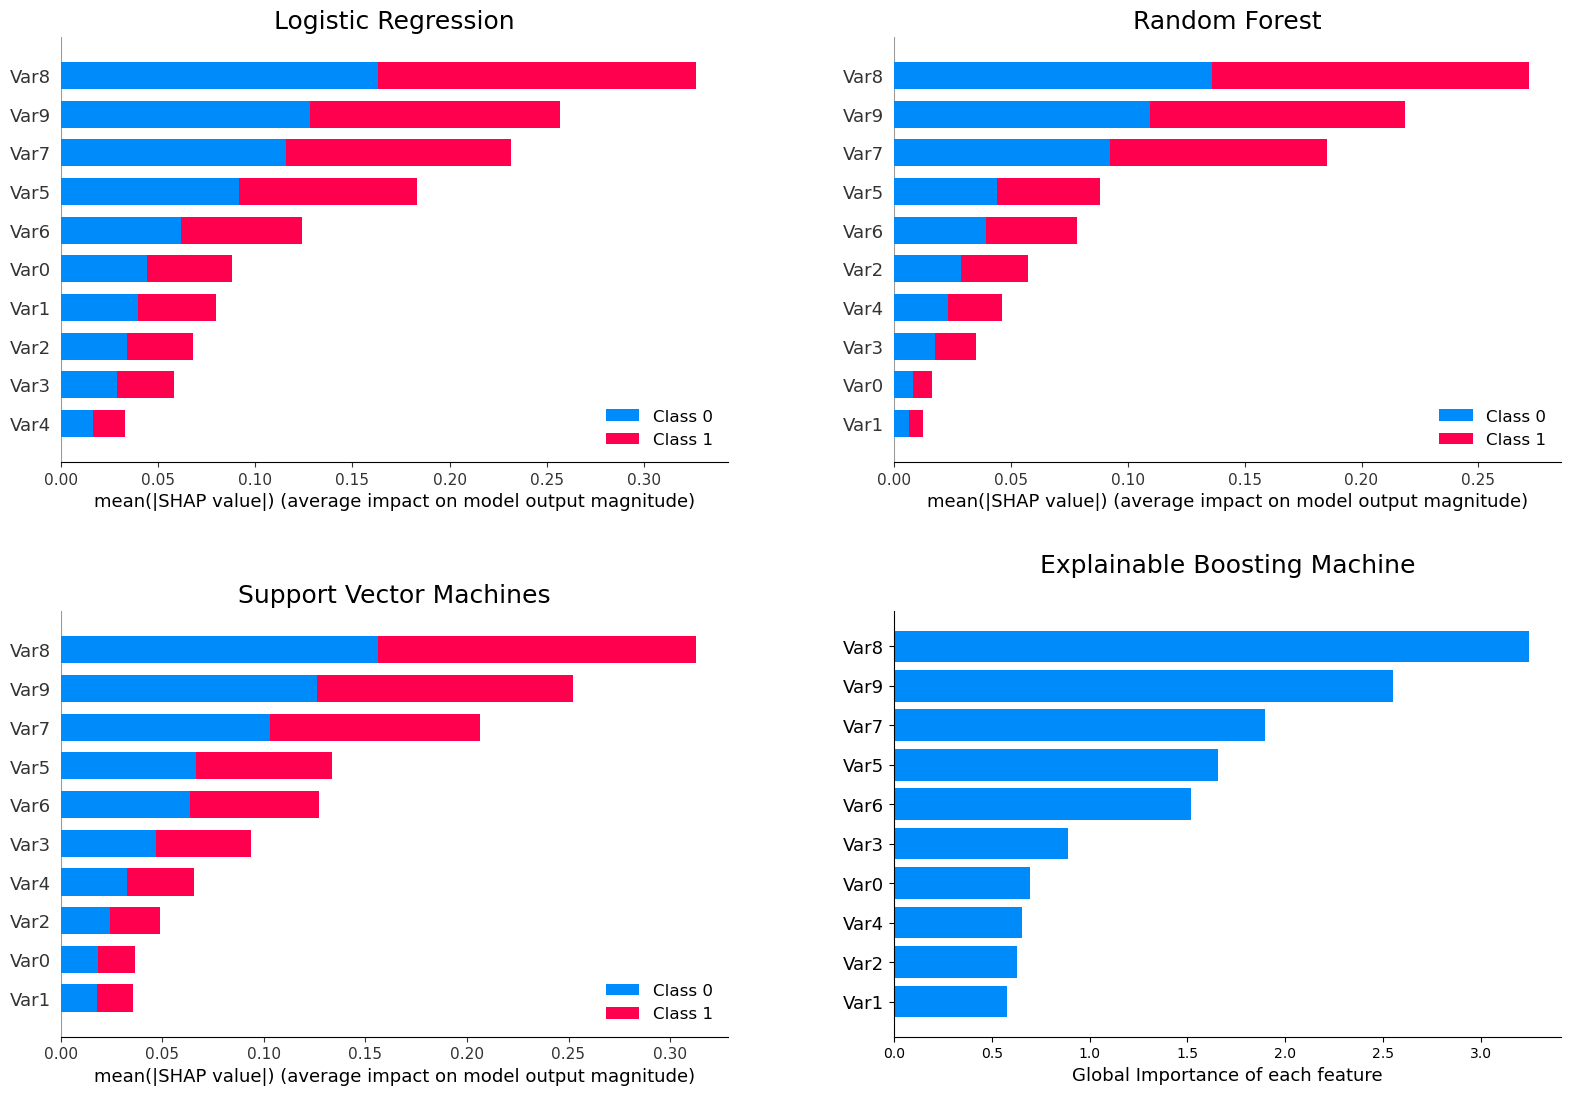

In [53]:
global_shap_values = [lr_shap_global_values,
                      rf_shap_global_values,
                      svm_shap_global_values]

visual.global_shap(global_shap_values,
                X_test_pd,
                  ebm_global.data(),
                  nrows = 2,
                  ncols = 2,
                  figsize = (15,10),
                  title_size = title_size,
                  label_size = label_size,
                  titles = ["Logistic Regression", "Random Forest", "Support Vector Machines"],
                  ebm_colors = shap_colors/255,
                  num_features = 20)

plt.savefig(f"{logs_dir}/synth_bin_test_global_SHAP_EBM.png", bbox_inches="tight")

plt.show()